In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import folium
import logging

from utils import *

from sklearn.metrics import root_mean_squared_error

logging.basicConfig(level=logging.INFO)

#### Preparando o dataset

In [2]:
data = pd.read_csv('../data/raw_data/data.csv')

In [3]:
# Separando o dataset em conjuntos de Treino e Teste
df_train, _,  df_test = split_data(data, 0.8, 0, 0.2)

In [4]:
print(df_train.shape[0])
print(df_test.shape[0])

5420
1355


In [5]:
# Selecionando as variáveis alvos
X_test = df_test.drop(['indoor', 'lat', 'lon'], axis=1)
y_test = df_test[['lat', 'lon']].values

#### Criando a função de Fingerprint

In [6]:
def fingerprint(df_train, test_instance):
    """
    Encontra o ponto no DataFrame de treino que está mais próximo do ponto de teste,
    considerando as colunas de RSSI e delay.
    """
    columns = [
        'rssi_1_1', 'rssi_1_2', 'rssi_1_3',
        'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
        'rssi_3_1', 'rssi_3_2', 'rssi_3_3',
        'delay_1', 'delay_2', 'delay_3'
    ]
    
    ref_point = test_instance[columns]
    
    # Euclidian distance
    distances = np.sqrt(((df_train[columns] - ref_point) ** 2).sum(axis=1))
    min_index = distances.idxmin()
    closest_point = df_train.loc[min_index]
    
    return closest_point['lat'], closest_point['lon']   

In [7]:
# Função para calcular a posição estimada para cada ponto
def fingerprint_predict(pontos_df):
    y_pred = []
    for _, ponto in pontos_df.iterrows():
        y_pred.append(fingerprint(df_train, ponto))

    return y_pred

#### Avaliando o modelo

In [8]:
y_pred = fingerprint_predict(X_test)

In [9]:
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.020894925825008855


In [10]:
accuracy = calculate_accuracy(y_pred, y_test)
print(f"Acurácia: {accuracy:.3f}")

Acurácia: 0.774


In [11]:
distances = get_error_distances(y_pred, y_test)
print_errors(distances)

Erro de localização médio: 20.939 metros
Erro mínimo: 0.0 metros
Erro máximo: 671.722 metros
Desvio Padrão do erro: 65.028 metros


#### BoxPlot

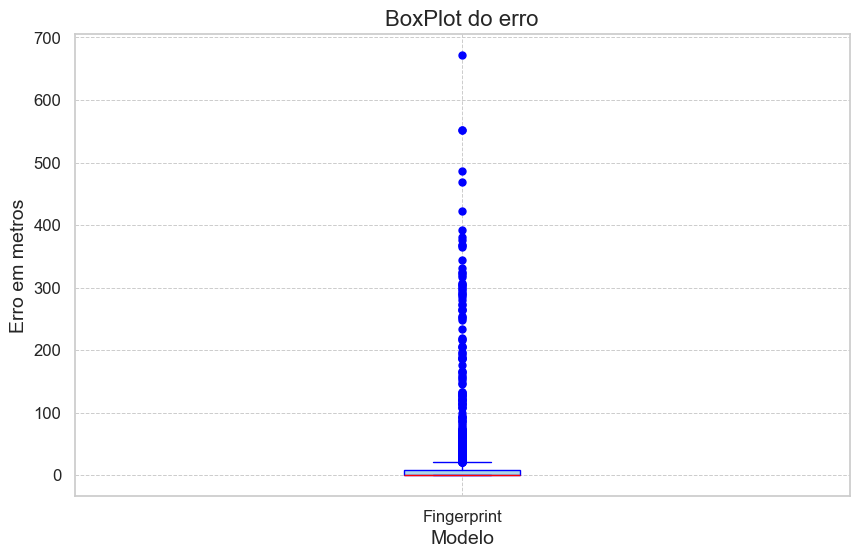

In [12]:
plot_boxplot('Fingerprint', distances)

#### Histograma dos Erros

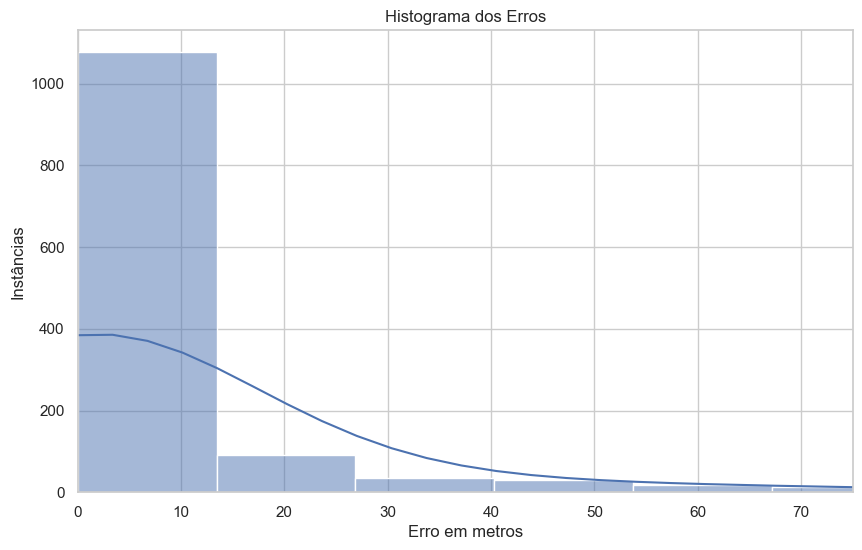

In [13]:
plot_histogram(distances, 75)

In [14]:
print(f"Total de distâncias: {len(distances)}")
print(f"Distâncias com menos de 25 Metros de erro: {np.sum(distances <= 25)}")

Total de distâncias: 1355
Distâncias com menos de 25 Metros de erro: 1154


#### Visualização dos Mapas

In [15]:
map = plot_folium_map(y_test, y_pred, True)
map

In [16]:
map = plot_folium_map(y_pred, y_test, False)
map

#### Criação do arquivo de submit

In [17]:
df_submit = pd.read_csv('../data/submit/Resultados_EquipeX_Metodo_Y.csv')

In [18]:
submit = df_submit.copy()
submit

ponto_id  rssi_1_1  rssi_1_2  rssi_1_3  rssi_2_1  rssi_2_2  rssi_2_3  \
0            0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1            3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2            8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
2899      9672  0.683007  0.427860  0.745375  0.338093  0.372425  0.513271   
2900      9674  0.660574  0.614986  0.745375  0.265625  0.373545  0.378663   
2901      9675  0.696515  0.272818  0.650478  0.293126  0.272255  0.369109   
2902      9677  0.701844  0.508683  0.657285  0.240302  0.295898  0.347393   
2903      9678  0.661693  0.500826  0.793046  0.241918  0.409099  0.349584   

      rssi_3_1  rssi_3_2  rssi_3_3   delay_1   delay_2   delay_3  
0     0.317523  0.527387  0.000000  0.571429  0.428571  0.285714  
1     0.317523  0.527387  0.000000  0.571429  0.428571  0.285714  
2     0.317523  0.494311  0.000000  0.571429  0.428571  0.285714  
3     0.317523  0.527387  0.000000  0.571429  0.428571  0.285714  
4     0.317523  0.527387  0.000000  0.571429  0.428571  0.285714  
...        ...       ...       ...       ...       ...       ...  
2899  0.344011  0.199565  0.284662  0.000000  0.571429  0.571429  
2900  0.344011  0.199565  0.280179  0.000000  0.571429  0.571429  
2901  0.400705  0.199565  0.298351  0.000000  0.571429  0.571429  
2902  0.379110  0.199565  0.330972  0.000000  0.571429  0.714286  
2903  0.341010  0.199565  0.330972  0.000000  0.571429  0.714286  

[2904 rows x 13 columns]

In [19]:
df_submit = df_submit.drop(['ponto_id'], axis=1)

In [20]:
y_pred = fingerprint_predict(df_submit)

In [21]:
y_pred = np.array(y_pred)

In [22]:
submit['lat_pred'] = y_pred[:, 0]
submit['lon_pred'] = y_pred[:, 1]

In [23]:
submit.drop([
    'rssi_1_1', 'rssi_1_2', 'rssi_1_3',
    'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
    'rssi_3_1', 'rssi_3_2', 'rssi_3_3',
    'delay_1', 'delay_2', 'delay_3'
], axis=1, inplace=True)

In [24]:
submit

ponto_id  lat_pred  lon_pred
0            0  -8.05475 -34.94652
1            3  -8.05475 -34.94652
2            8  -8.05475 -34.94652
3           10  -8.05475 -34.94652
4           12  -8.05475 -34.94652
...        ...       ...       ...
2899      9672  -8.05475 -34.94652
2900      9674  -8.05475 -34.94652
2901      9675  -8.05475 -34.94652
2902      9677  -8.05475 -34.94652
2903      9678  -8.05475 -34.94652

[2904 rows x 3 columns]

In [25]:
submit.to_csv(f'../data/submit/Resultados_Equipe5_Metodo_Fingerprint.csv', index=False)